<a href="https://colab.research.google.com/github/abhijitpanda890/ML1-Sentiment-analysis-and-emotion-detection-/blob/main/(Robust)Sentiment_Analysis(Yelp_Polarity_reviews).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import re
import shutil
import string
import tqdm
from tensorflow.keras import Model, preprocessing
from tensorflow.keras.layers import Dot, Embedding , Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
from tensorflow import keras

import tensorflow_datasets as tfds
import tensorflow as tf

from keras import backend as K


tfds.disable_progress_bar()

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [17]:
dataset, info = tfds.load('yelp_polarity_reviews', with_info=True,
                          as_supervised=True) #download the dataset
train_dataset, test_dataset = dataset['train'], dataset['test'] #segregate the train and test datasets

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [18]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"The Groovy P. and I ventured to his old stomping grounds for lunch today.  The '5 and Diner' on 16th St and Colter left me with little to ask for.  Before coming here I had a preconceived notion that 5 & Diners were dirty and nasty. Not the case at all.\\n\\nWe walk in and let the waitress know we want to sit outside (since it's so nice and they had misters).  We get two different servers bringing us stuff (talk about service) and I ask the one waitress for recommendations.  I didn't listen to her, of course, and ordered the Southwestern Burger w/ coleslaw and started with a nice stack of rings.\\n\\nThe Onion Rings were perfectly cooked.  They looked like they were prepackaged, but they were very crispy and I could actually bite through the onion without pulling the entire thing out (don't you hate that?!!!)\\n\\nThe Southwestern Burger was order Medium Rare and was cooked accordingly.  Soft, juicy, and pink with a nice crispy browned outer layer that can only be achieved on 

In [19]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

In [20]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Food is ok. Drinks look good but haven't tried them. Great live jazz."
 b"I wouldn't even enjoy this place on a late Friday night:  My friend's chicken n waffles tasted like it had just survived a long, long tornado then been reheated. My dish, the chicken florentine-which I'd so enjoyed mere days prior @ the sahara location(so much better)- tasted more like cheap casino sirloin than chicken and sauce.\\n\\nService also sucked here... One of those places w/o a host, where you're ignored 10 minutes until a graceful angel of unknown origin addresses you. Definitely avoid this location. There's an amazing similar restaurant nearby called rise n shine(?)."
 b'Came here with my sister in law she had a coupon for a 27.99 mani/ spa pedi. The staff was friendly they have a tv and plenty of magazines to look through. I got a french tip mani and spa pedi with a flower. The guy did a great job our nails look gorgeous!']

labels:  [1 0 1]


In [22]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)  #preprocessing and vectorization of data
encoder.adapt(train_dataset.map(lambda text, label: text))

In [23]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]
encoded_example = encoder(example)[:3].numpy() #modified data after text vectorization
encoded_example

array([[ 30,  12, 251, ...,   0,   0,   0],
       [  4, 416,  74, ...,   0,   0,   0],
       [ 98,  45,  17, ...,   0,   0,   0]])

In [24]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Food is ok. Drinks look good but haven't tried them. Great live jazz."
Round-trip:  food is ok drinks look good but havent tried them great live [UNK]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [25]:
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True), #parameters:size of vocabulary, output-dimensions, mask(explained in README)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),#RNN Layer with 64 LSTM units
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),#RNN Layer with 32 LSTM units
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [26]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),# using the BinaryCrossentropy as loss function for a binary classifier
              optimizer=tf.keras.optimizers.Adam(1e-4),#adam as optimizer
              metrics=['accuracy', f1_m,precision_m, recall_m])

In [28]:
 history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                     callbacks=[early_stopping])

Epoch 1/10
2188/2188 [==============================] - 567s 249ms/step - loss: 0.2942 - accuracy: 0.8582 - f1_m: 0.8142 - precision_m: 0.8603 - recall_m: 0.7785 - val_loss: 0.2270 - val_accuracy: 0.8987 - val_f1_m: 0.8964 - val_precision_m: 0.9325 - val_recall_m: 0.8636
Epoch 2/10
2188/2188 [==============================] - 529s 242ms/step - loss: 0.2325 - accuracy: 0.9014 - f1_m: 0.8974 - precision_m: 0.9326 - recall_m: 0.8658 - val_loss: 0.2223 - val_accuracy: 0.9007 - val_f1_m: 0.8985 - val_precision_m: 0.9344 - val_recall_m: 0.8660
Epoch 3/10
2188/2188 [==============================] - 535s 244ms/step - loss: 0.2268 - accuracy: 0.9035 - f1_m: 0.8996 - precision_m: 0.9334 - recall_m: 0.8692 - val_loss: 0.2275 - val_accuracy: 0.8931 - val_f1_m: 0.8873 - val_precision_m: 0.9537 - val_recall_m: 0.8303
Epoch 4/10
2188/2188 [==============================] - 531s 242ms/step - loss: 0.2210 - accuracy: 0.9057 - f1_m: 0.9021 - precision_m: 0.9346 - recall_m: 0.8728 - val_loss: 0.2165 - v

In [29]:
test_loss, test_acc, f1_score, precision, recall = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)




149/149 [==============================] - 13s 88ms/step - loss: 0.1710 - accuracy: 0.9304 - f1_m: 0.9293 - precision_m: 0.9406 - recall_m: 0.9188
Test Loss: 0.17096687853336334
Test Accuracy: 0.93039470911026
Test Precision: 0.9406332969665527
Test Recall: 0.9187859892845154
Test F1 Score: 0.929294764995575


(0.0, 0.3000441573560238)

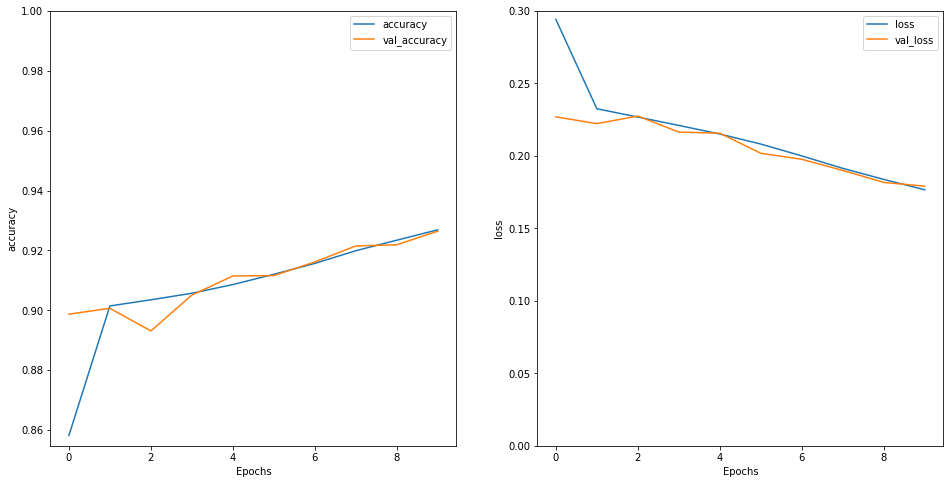

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [31]:

!mkdir -p saved_model
model.save('saved_model/SA_model')

INFO:tensorflow:Assets written to: saved_model/SA_model/assets


INFO:tensorflow:Assets written to: saved_model/SA_model/assets
